In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from definitions import RAW_DATA_DIR
from src.models.strategies import RSIStoch200EMAResults

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
btcusdt = pd.read_csv(RAW_DATA_DIR / 'BTCUSDT.csv')
btcusdt.index = pd.DatetimeIndex(btcusdt['open time'])

In [10]:
from src.data.indicators import rsi, stochRSI, stoch_k, stoch_d, ema

In [29]:
btcusdt['rsi'] = rsi(ohlc=btcusdt, period=14)
btcusdt['stoch_k'], btcusdt['stoch_d'] = stochRSI(
    ohlc=btcusdt, period=14, smoothK=3, smoothD=3
)
btcusdt['ema'] = ema(ohlc=btcusdt, period=200)

In [30]:
btcusdt

,open time,open,high,low,close,volume,rsi,stoch_k,stoch_d,ema
open time,,,,,,,,,,
2017-08-17 20:30:00,2017-08-17 20:30:00,4301.91,4354.84,4262.53,4346.74,15.184266,NaN,NaN,NaN,4346.740000
2017-08-17 21:00:00,2017-08-17 21:00:00,4346.74,4369.69,4315.85,4349.33,29.292665,100.000000,NaN,NaN,4346.765771
2017-08-17 21:30:00,2017-08-17 21:30:00,4349.33,4369.69,4309.23,4333.55,32.480371,13.225186,NaN,NaN,4346.634271
2017-08-17 22:00:00,2017-08-17 22:00:00,4333.55,4349.63,4310.00,4326.29,26.241174,9.248769,NaN,NaN,4346.431840
2017-08-17 22:30:00,2017-08-17 22:30:00,4326.29,4359.13,4319.11,4336.80,31.134968,38.211911,NaN,NaN,4346.336001
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 21:30:00,2021-05-31 21:30:00,36775.02,37087.30,36623.01,36932.55,840.717074,58.482794,0.198487,0.133164,36229.710395
2021-05-31 22:00:00,2021-05-31 22:00:00,36932.55,37250.00,36863.28,37090.16,1407.839699,61.498708,0.419132,0.235186,36238.272082
2021-05-31 22:30:00,2021-05-31 22:30:00,37090.16,37140.00,36835.85,36879.23,908.355699,55.670255,0.430699,0.349439,36244.649773


In [22]:
results = RSIStoch200EMAResults(
    asset_name='BTCUSDT',
    ohlcv_timeseries=btcusdt
)

In [23]:
start_time = btcusdt.index[-600]
end_time = btcusdt.index[-400]
fin_data = btcusdt[start_time:end_time]


min_period_to_last_low = 5

running_divergences = []
true_divergence = None
wait_for_stoch_cross = False
current_pattern = {}
current_trade = {}

for idx in range(1, len(fin_data)-1):
    row = fin_data.iloc[idx]
    if np.isnan(row['ema']) or np.isnan(row['rsi']) or \
       np.isnan(row['stoch_k']) or np.isnan(row['stoch_d']):
        continue
    if np.isnan(fin_data.iloc[idx-1]['rsi']):
        continue
    # Scan for low on RSI
    if (row['rsi'] < fin_data.iloc[idx-1]['rsi']) and (row['rsi'] < fin_data.iloc[idx+1]['rsi']):
        for potential_div in running_divergences:
            # Update threshold
            threshold = potential_div['t1_rsi'] + (idx - potential_div['t1_idx']) * potential_div['slope']
            potential_div['threshold'] = threshold  # Safe to clear thresholds < 0
            # Look for divergences
            if row['rsi'] < threshold:
                # Update slope
                delta_y = row['rsi'] - potential_div['t1_rsi']
                delta_x = idx - potential_div['t1_idx']
                potential_div['slope'] = delta_y / delta_x
                # Descending RSI -> potential divergence spotted
                if idx - potential_div['t1_idx'] >= min_period_to_last_low:
                    past_row = fin_data.loc[potential_div['t1']]
                    if min(past_row['close'], past_row['open']) < min(row['close'], row['open']):
                        # Divergence found!
                        wait_for_stoch_cross = True
                        potential_div['t2'] = row.name
                        potential_div['t2_idx'] = idx
                        potential_div['t2_rsi'] = row['rsi']
                        true_divergence = potential_div
        # Remember this low on RSI
        new_potential_div = {}
        new_potential_div['t1'] = row.name
        new_potential_div['t1_idx'] = idx
        new_potential_div['t1_rsi'] = row['rsi']
        new_potential_div['slope'] = 0
        new_potential_div['threshold'] = row['rsi']
        running_divergences.append(new_potential_div)
        # Remove all positions with threshold < 0
        running_divergences = [d for d in running_divergences if d['threshold'] > 0]
        
    if wait_for_stoch_cross:
        # Check for cross of stochastic RSI
        old_stoch_delta = fin_data.iloc[idx-1]['stoch_k'] - fin_data.iloc[idx-1]['stoch_d']
        new_stoch_delta = fin_data.iloc[idx]['stoch_k'] - fin_data.iloc[idx]['stoch_d']
        if old_stoch_delta * new_stoch_delta < 0:
            # Cross found!
            current_pattern = {
                'divergence_timeframe': (true_divergence['t1'], true_divergence['t2'])
            }
            current_trade = {
                'entry_time': row.name,
                'entry_price': row['close'],
                'take_profit': row['close'] + 100,
                'stop_loss': row['close'] - 50,
                'exit_time': fin_data.index[min(idx+10, 149)],
                'win': True
            }
            results.add_trade_and_signal(**current_trade, **current_pattern)
            wait_for_stoch_cross = False

In [90]:
results = RSIStoch200EMAResults(
    asset_name='BTCUSDT',
    ohlcv_timeseries=btcusdt
)

start_time = btcusdt.index[-600]
end_time = btcusdt.index[-400]
fin_data = btcusdt[start_time:end_time]


min_period_to_last_low = 5
swing_low_margin = 2

running_divergences = []
true_divergence = None
wait_for_stoch_cross = False
current_pattern = {}
current_trade = {}

for idx in range(1, len(fin_data)-1):
    row = fin_data.iloc[idx]
    if np.isnan(row['ema']) or np.isnan(row['rsi']) or \
       np.isnan(row['stoch_k']) or np.isnan(row['stoch_d']):
        continue
    if np.isnan(fin_data.iloc[idx-1]['rsi']):
        continue
        
    for potential_div in running_divergences:
        # Update threshold
        threshold = potential_div['t1_rsi'] + (idx - potential_div['t1_idx']) * potential_div['slope']
        potential_div['threshold'] = threshold
        # Scan for lower RSI value
        if row['rsi'] < potential_div['threshold']:
            # Update slope
            delta_y = row['rsi'] - potential_div['t1_rsi']
            delta_x = idx - potential_div['t1_idx']
            potential_div['slope'] = delta_y / delta_x
            # Is this a local low on RSI? -> potential divergence spotted
            if (row['rsi'] < fin_data.iloc[idx-1]['rsi']) and (row['rsi'] < fin_data.iloc[idx+1]['rsi']):
                if idx - potential_div['t1_idx'] >= min_period_to_last_low:
                    past_row = fin_data.loc[potential_div['t1']]
                    # Check if there is a higher low on price
                    if min(past_row['close'], past_row['open']) < min(row['close'], row['open']):
                        # Divergence found!
                        wait_for_stoch_cross = True
                        potential_div['t2'] = row.name
                        potential_div['t2_idx'] = idx
                        potential_div['t2_rsi'] = row['rsi']
                        true_divergence = potential_div
                    
    # Remove all positions with threshold < 0
    running_divergences = [d for d in running_divergences if d['threshold'] > 0]
                
    # Save new lows on RSI
    if (row['rsi'] < fin_data.iloc[idx-1]['rsi']) and (row['rsi'] < fin_data.iloc[idx+1]['rsi']):
        new_potential_div = {}
        new_potential_div['t1'] = row.name
        new_potential_div['t1_idx'] = idx
        new_potential_div['t1_rsi'] = row['rsi']
        new_potential_div['slope'] = 0
        new_potential_div['threshold'] = row['rsi']
        running_divergences.append(new_potential_div)
        
    if wait_for_stoch_cross:
        # Check for cross of stochastic RSI
        old_stoch_delta = fin_data.iloc[idx-1]['stoch_k'] - fin_data.iloc[idx-1]['stoch_d']
        new_stoch_delta = fin_data.iloc[idx]['stoch_k'] - fin_data.iloc[idx]['stoch_d']
        if old_stoch_delta * new_stoch_delta < 0:
            # Cross found! Place trade.
            current_pattern = {
                'divergence_timeframe': (true_divergence['t1'], true_divergence['t2'])
            }
            current_trade = {
                'entry_time': row.name,
                'entry_price': row['close'],
                'take_profit': None,
                'stop_loss': None,
                'exit_time': None,
                'win': None
            }
            # Look for nearest swing low
            idx_swing_low = idx
            while True:
                surrounding_idx = [
                    idx_swing_low + j for j in range(-swing_low_margin, swing_low_margin+1) if j != 0
                ]
                valid_idx = set(surrounding_idx).intersection(range(1, idx+1))
                if fin_data.iloc[idx_swing_low]['low'] < current_trade['entry_price'] \
                    and fin_data.iloc[idx_swing_low]['low'] < fin_data.iloc[list(valid_idx)]['low'].min():
                    # Swing low found. Place stop loss and take profit.
                    current_trade['stop_loss'] = 0.999 * fin_data.iloc[idx_swing_low]['low']
                    current_trade['take_profit'] = current_trade['entry_price'] \
                        + 2 * (current_trade['entry_price'] - current_trade['stop_loss'])
                    break
                idx_swing_low = idx_swing_low-1
            # Find trade exit
            for idx_future in range(idx, len(fin_data)-1):
                if current_trade['stop_loss'] > fin_data.iloc[idx_future]['low']:
                    # Stopp loss target hit
                    current_trade['exit_time'] = fin_data.iloc[idx_future].name
                    current_trade['win'] = False
                    break
                if current_trade['take_profit'] < fin_data.iloc[idx_future]['high']:
                    # Take profit target hit
                    current_trade['exit_time'] = fin_data.iloc[idx_future].name
                    current_trade['win'] = True
                    break
            
            results.add_trade_and_signal(**current_trade, **current_pattern)
            wait_for_stoch_cross = False

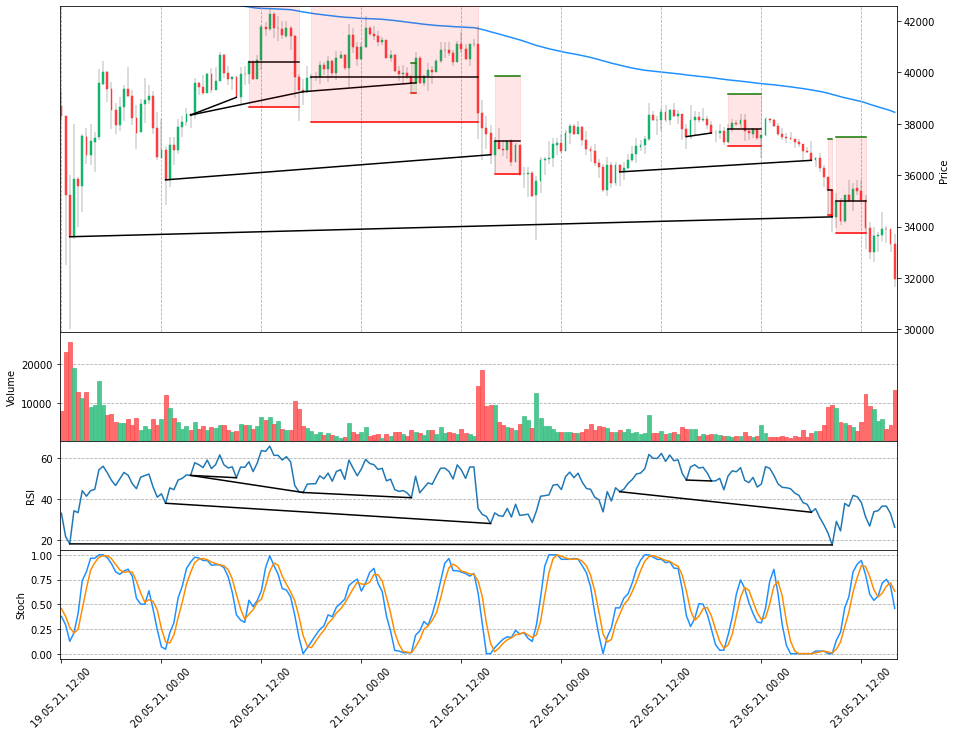

In [91]:
results.plot(start_time, end_time)

In [1]:
running_divergences

NameError: name 'running_divergences' is not defined

In [42]:
for idx, row in fin_data.iterrows():
    if np.isnan(row['ema']) or np.isnan(row['rsi']) or \
       np.isnan(row['stoch_k']) or np.isnan(row['stoch_d']):
        continue
    if np.isnan
    print(row['ema'])

4159.693055826378
4201.9375311813055
4132.416740180774
4128.56997455209
4187.777846755228
4166.392530349039
4215.740813223205
4092.3401480312755
4164.880853657403
4094.6877465564617
4226.674954329694
4128.175205479889
4147.113264143441
4178.7373877955115
4209.421735570757
4126.810685679321
4088.640543375602
4199.0330366104
4139.32819835038
4170.978100151302
4212.685812608257
4103.783128403382
4126.401993145524
4156.042810069008
4250.207093211651
4111.176841877506
4221.576475257511
4066.259706144437
4114.686308702339
4129.737648764627
4203.958919744789
4185.123531939757
4157.012674892563
4086.0271778527563
4139.380438938635
4108.190317271218
4180.263293806858
4175.152255193084
4205.4273230151075
4114.931514092408
4190.764532048356
4276.513491164132
4233.115535716166
4211.393926759334
4050.9164628688277
4204.29046457209
4188.90802716909
4171.417655224803
4237.7759634316
4145.832710180929
4091.8099488445696
4197.156604464075
4130.781842619172
4224.084293496618
4127.989479423466
4132.88327

In [41]:
x = np.NaN
np.isnan(x)

True